In [1]:
import grizli

try: 
    from mastquery import query, overlaps
    use_mquery = True
except: 
    from hsaquery import query, overlaps
    use_mquery = False

import os
import numpy as np
from IPython.display import Image
from grizli.pipeline import auto_script
import glob
from glob import glob
import astropy
from grizli.prep import process_direct_grism_visit
from astropy.io import fits

In [2]:
field           = 'GS1'
ref_filter      = 'F105W'

HOME_PATH       = '/Users/vestrada/Grism_fields/{0}'.format(field)
PATH_TO_CATS    = '/Users/vestrada/Data/CLEAR/CATALOGS'

# Create [HOME_PATH] and [HOME_PATH]/query_results directories if they do not already exist
if not os.path.isdir(HOME_PATH): os.system('mkdir %s'%HOME_PATH)
if not os.path.isdir(HOME_PATH + '/query_results'): os.system('mkdir %s/query_results'%HOME_PATH)

# Move to the [HOME_PATH] directory
os.chdir(HOME_PATH)

In [3]:
# proposal_id = [14227] is CLEAR
parent = query.run_query(box = None, proposal_id = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters = ['G102'], target_name = 'GS1')

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1
          GS1 

filter j0333m2742          WFC3/IR G102    6   27670.5
filter j0333m2742          WFC3/IR G141    1    4711.7


0

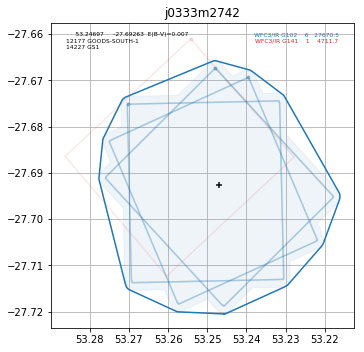

In [4]:
# Find all G102 and G141 observations overlapping the parent query in the archive
tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.1, 
                              filters=['G102', 'G141'], 
                              instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], close=False)

footprint_fits_file = glob('*footprint.fits')[0]
jtargname = footprint_fits_file.strip('_footprint.fits')


# A list of the target names
fp_fits = fits.open(footprint_fits_file)
overlapping_target_names = set(fp_fits[1].data['target'])


# Move the footprint figure files to $HOME_PATH/query_results/ so that they are not overwritten
os.system('cp %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, 'all_G102_G141'))
os.system('cp %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
target_name
-----------
        GS1 

filter j0333m2742         WFC3/IR F105W    6    3185.2
filter j0333m2742          WFC3/IR G102    6   27670.5


OSError: Header missing END card.

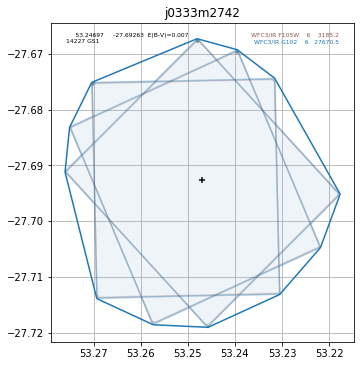

In [5]:
# Loop targ_name by targ_name
for t, targ_name in enumerate(overlapping_target_names):
    if use_mquery:
        extra = {'target_name':targ_name}
    else:
        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%targ_name]
    
    # search the MAST archive again, this time looking for 
    # all grism and imaging observations with the given target name
    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                                  filters=['G102', 'G141', 'F098M', 'F105W', 'F125W', 'F140W'], 
                                  instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], 
                                  extra=extra, close=False)
    if True:
        # retrieve raw data from MAST
        s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
        auto_script.fetch_files(field_root=jtargname, HOME_PATH=HOME_PATH, remove_bad=True, 
                                reprocess_parallel=True, s3_sync=(s3_status == 0))

    # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
    os.system('mv %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))

    os.chdir(HOME_PATH)

In [17]:
PATH_TO_RAW     = glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob(HOME_PATH + '/*/PREP')[0]

# Move to the Prep directory
os.chdir(PATH_TO_PREP)

In [19]:
# Find all pre-processed flt files in the RAW directory
files = glob('%s/*flt.fits'%PATH_TO_RAW)
# Generate a table from the headers of the flt fits files
info = grizli.utils.get_flt_info(files)

UnboundLocalError: local variable 'has_columns' referenced before assignment

In [6]:

import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script
from grizli import utils, fitting, multifit

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-4-g1153432


Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1
          GS1 

filter j0333m2742          WFC3/IR G102    6   27670.5
filter j0333m2742          WFC3/IR G141    1    4711.7


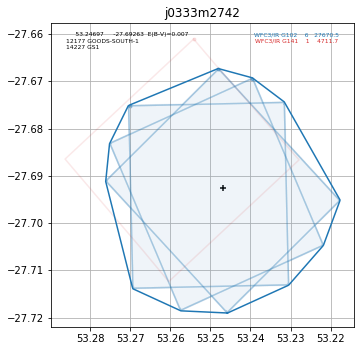

In [7]:
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]

parent = query.run_query(box = None, proposal_id = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters = ['G102'], target_name = 'GS1')

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['G102', 'G141'], 
                              instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], close=False)


In [9]:
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                ','.join(np.unique(tab['filter']))))

Footprint files:  ['j0333m2742_footprint.fits']

# id            ra         dec        e(b-v)   filters
j0333m2742  53.24697  -27.69263   0.0067   G102,G141


In [10]:
root = 'j0333m2742'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if True:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,20], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

OSError: Header missing END card.